# Проект 02 – Разведочный анализ

## 1. Exploratory Data Analysis

**Pandas** — это одна из самых популярных библиотек Python для работы с табличными данными. Она предоставляет удобные 
структуры данных:
* **Series** — одномерный массив с индексами, похожий на колонку в таблице;
* **DataFrame** — двумерная таблица, где каждая колонка может иметь свой тип данных.

С помощью Pandas можно: фильтровать строки и столбцы, группировать данные, агрегировать показатели, объединять таблицы, 
работать с пропущенными значениями и строить простые визуализации. Владение Pandas — базовый и необходимый навык для 
проведения EDA.

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

### Задание 1.1. Загрузка данных
1. Зарегистрируйся на [Kaggle](https://www.kaggle.com/)
2. Перейди на страницу датасета [2025 Kaggle Machine Learning & Data Science Survey](https://www.kaggle.com/datasets/sonialikhan/2025-kaggle-machine-learning-and-data-science-survey)
3. Скачай CSV-файлы с данными и сохрани их в папку `datasets`
4. С помощью библиотеки `pandas` загрузи:
   * таблицу с выбором ответов (multiple choice) в переменную `multuple`
   * таблицу со свободными ответами (free form) `freeform`
5. Выведи размеры каждой таблицы
   
> **Важно:** загружать датасеты на Git не нужно.

In [2]:
freeform = pd.read_csv("../assets/project2/2025/freeFormResponses.csv", low_memory=False)

In [3]:
multiple = pd.read_csv("../assets/project2/2025/multipleChoiceResponses.csv", low_memory=False)

In [4]:
freeform.shape

(23860, 35)

In [5]:
multiple.shape

(23860, 395)

In [6]:
schema = pd.read_csv("../assets/project2/2025/SurveySchema.csv", low_memory=False)

### Задание 1.2. Совмещение таблиц
1. Найди общие колонки в таблицах `multiple` и `freeform`. Выведи их количество
2. Определи количество уникальных значений в колонке `Q1_OTHER_TEXT` для обеих таблиц, включая `NaN`.
3. Используя метод `.update()`, дополни DataFrame `multiple` данными из DataFrame `freeform`.
4. Переименуй дополненный DataFrame в `responses`.
5. Выведи количество уникальных значений в колонке `Q1_OTHER_TEXT` для таблицы `responses`, включая `NaN`.


In [7]:
freeform_columns = set(freeform.columns)
multiple_columns = set(multiple.columns)

In [8]:
over_lapper_columns = list(freeform_columns.intersection(multiple_columns))
len(over_lapper_columns)

35

In [9]:
multiple["Q1_OTHER_TEXT"].value_counts(dropna=False)

Q1_OTHER_TEXT
-1    23780
42        4
25        4
20        3
14        2
      ...  
31        1
32        1
33        1
35        1
67        1
Name: count, Length: 68, dtype: int64

In [10]:
freeform["Q1_OTHER_TEXT"].value_counts(dropna=False)

Q1_OTHER_TEXT
NaN                          23780
non-binary                       4
Agender                          4
Non-binary                       3
Male                             2
                             ...  
Transgender Female               1
genderless                       1
Nonbinary (born female)          1
bigender                         1
Apache Attack Helicopter         1
Name: count, Length: 68, dtype: int64

In [11]:
multiple.update(freeform, overwrite=True)

In [12]:
responses = multiple

In [13]:
responses["Q1_OTHER_TEXT"].value_counts(dropna=False)

Q1_OTHER_TEXT
-1                           23702
42                               4
25                               4
Agender                          4
non-binary                       4
                             ...  
24                               1
shemale                          1
23                               1
22                               1
Apache Attack Helicopter         1
Name: count, Length: 133, dtype: int64

### Задание 1.3. Словарь вопросов
В таблице `responses` первая строка содержит текстовые формулировки вопросов
(например: *'What is your gender? - Selected Choice'*, *'What is your age (# years)?'* и т. д.), а сами данные 
начинаются со второй строки.

1. Преврати первую строку таблицы `responses` в словарь и сохрани его в переменную `column2question`, где ключами 
будут названия колонок, а значениями — формулировки вопросов.
2. Удали эту строку из таблицы `responses`.
3. Выведи тип переменной `column2question`.
4. Выведи размерность таблицы `responses` после удаления первой строки.


In [14]:
name2question1 = responses.iloc[0].to_dict()

In [15]:
name2question1['Q1']

'What is your gender? - Selected Choice'

In [16]:
type(name2question1)

dict

In [17]:
responses = responses.drop(0)
responses.shape

(23859, 395)

### Задание 1.4. Очистка респондентов

В данных есть информация о времени заполнения опроса. Логично предположить, что если респондент отвечал **слишком быстро** или, наоборот, **слишком долго**, такие ответы могут быть недостоверными. Для очистки данных воспользуемся методом выявления выбросов на основе **box plot**.

**Box plot (ящик с усами)** — это способ визуализации распределения данных. Внутри прямоугольника (ящика) находятся значения от 1-го до 3-го квартиля (Q1 и Q3), линия внутри — это медиана. «Усы» обычно определяются через **интерквартильный размах (IQR)**, который равен:

$$IQR = Q3 - Q1$$
Значения ниже $Q1 - 1.5 \times IQR$ и выше $Q3 + 1.5 \times IQR$ считаются выбросами.

1. Построй box plot для времени заполнения опроса. Ограничь ось **X** от 0 до 5000 секунд.
2. Рассчитай интерквартильный размах (IQR).
3. Выведи нижнюю и верхнюю границы интервала для выявления выбросов.
4. Так как нижняя граница получилась отрицательной, будем априорно считать минимальное адекватное время заполнения равным **2 минутам (120 секунд)**.
5. Отфильтруй DataFrame, оставив только респондентов с временем заполнения от 120 секунд до верхней границы.
6. Выведи размерность очищенного датасета.

In [18]:
responses["Time from Start to Finish (seconds)"] = responses["Time from Start to Finish (seconds)"].astype(int)

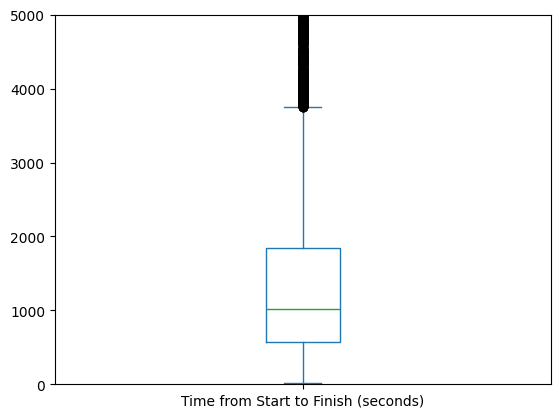

In [19]:
responses["Time from Start to Finish (seconds)"].plot.box()
plt.ylim(0, 5000)
plt.show();

In [20]:
Q1 = np.percentile(responses["Time from Start to Finish (seconds)"], 25)
Q3 = np.percentile(responses["Time from Start to Finish (seconds)"], 75)
IQR = Q3 - Q1
print(IQR)

1272.0


In [21]:
upper = Q3+1.5*IQR
print("Upper Bound:", upper)

lower = Q1-1.5*IQR
print("Lower Bound:", lower)

Upper Bound: 3750.0
Lower Bound: -1338.0


In [22]:
responses = responses[
    (responses["Time from Start to Finish (seconds)"] < upper) & 
    (responses["Time from Start to Finish (seconds)"] > 120)
]

In [23]:
responses.shape

(18696, 395)